<a href="https://colab.research.google.com/github/SkipperNZ/speech-recognition/blob/master/hw5/asr_lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Практика №3

Теперь в качестве акустической модели мы будем использовать простой DNN классификатор. На каждом кадре записи мы будем подавать его вектор признаков на DNN, которая будет выдавать "распределение вероятностей" по фонемам. Далее это распределение мы будем использовать в нашем алгоритме распознавания по словарю. Схема работы такого классификатора представлена ниже: 

![](https://drive.google.com/uc?export=view&id=1dv0VuE8DIoKXETbvnZq2PMixkWMCJOxr)

### Bootstrap

In [4]:
!pip install --upgrade --no-cache-dir gdown

!gdown --id '1meikF0XqBUnVZKoY3160MQ0R25lq-EMu'
!gdown --id '1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox'

!unzip -q lab2.zip
!unzip -q train_librispeech_10h.zip
!mv lab2 lab3
!mv train_librispeech_10h lab3/data
!rm -rf lab2.zip sample_data train_librispeech_10h.zip
%cd lab3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1meikF0XqBUnVZKoY3160MQ0R25lq-EMu
To: /content/lab3/lab2.zip
100% 1.66M/1.66M [00:00<00:00, 192MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox
To: /content/lab3/train_librispeech_10h.zip
100% 679M/679M [00:02<00:00, 308MB/s]
/content/lab3/lab3


In [5]:
import os
import numpy as np
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display
import torch
import torch.nn as nn
import torch.functional as F


%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [6]:
# загрузка списка допустимых фонем:
def load_phones_dict(phones_file):
    phones_dict = {}
    with open(phones_file, encoding='utf-8') as fn:
        for index, line in enumerate(fn):
            phones_dict[line.strip()] = index
    return phones_dict

# загрузка покадровой фонемной разметки в словарь:
def load_phone_aligment(aligment_file):
    ali_dict = {}
    with open(aligment_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            ali_dict[line[0]] = line[1:]
    return ali_dict

# подсчет акустиеских признаков для записей из папки:
def load_data_dict(dir_path, count=None):
    data_dict = {}
    step = 0
    for wav_name in tqdm(os.listdir(dir_path)):
        x, sr = librosa.load(os.path.join(dir_path, wav_name), sr=None) 
        mfcc = librosa.feature.mfcc(x,
                                    sr=sr,
                                    n_mfcc=13, 
                                    n_fft=int(sr * 0.025),
                                    hop_length=int(sr * 0.01))
        step += 1
        if count and step == count:
            print(f'Early stop at {step}th file..')
            break
        data_dict[wav_name.split('.')[0]] = mfcc.T  
    return data_dict


phones_file = 'data/train_librispeech_10h/phones'
phones_dict = load_phones_dict(phones_file)

ali_file = 'data/train_librispeech_10h/ali_phones.txt'
ali_dict = load_phone_aligment(ali_file)

train_records_dir = 'data/train_librispeech_10h/wav_dir'
feats_dict = load_data_dict(train_records_dir, count=1000)

  0%|          | 0/3000 [00:00<?, ?it/s]

Early stop at 1000th file..


### Априорная вероятность:

![](https://drive.google.com/uc?export=view&id=1WhjclhXm2POYsCgvxp3iAIOvT9F_k8If)

http://data-science.wiki/images/Automatic_Speech_Recognition_RxtNVMXYTy.pdf

In [31]:
def make_side_context(data, side_context=0):
  contexted_data_list = []
  #Сделаем падинг
  data = np.pad(data, pad_width=((side_context, side_context), (0, 0)), mode='edge')
  
  for frame in range(side_context, len(data)-side_context):
    frame_number = list(range(frame - side_context, frame + side_context + 1))
    contexted_data_list.append(np.concatenate([data[x] for x in frame_number]))
  
  return np.asarray(contexted_data_list)



In [43]:
# объединение кадров признаков с соответствующими им фонемам:
def combain_data(ali_dict, feats_dict, phones_dict, side_context=None):
    data_list = []
    priors_list = [0] * len(phones_dict)
    for file_name in feats_dict.keys():
        file_feats = feats_dict[file_name]

        file_feats = make_side_context(file_feats, side_context=side_context)

        file_ali = ali_dict[file_name]

        for frame in range(min(len(file_feats), len(file_ali))):

            data_list.append(np.append(file_feats[frame], phones_dict[file_ali[frame]]))
            priors_list[phones_dict[file_ali[frame]]] += 1

    return data_list, np.array(priors_list)/sum(priors_list)


side_context = 5
data_list, priors_list = combain_data(ali_dict, feats_dict, phones_dict, side_context)
data_list = np.random.permutation(data_list)

In [8]:
class CommonDataSet():

    def __init__(self, data_list, device, valid_proportion=0.1):
        self.train = data_list[:int((1-valid_proportion)*len(data_list))]
        self.valid = data_list[int((1-valid_proportion)*len(data_list)):]
        self.device = device
        
    def num_batches(self, batch_size):
        return len(self.train)//batch_size        
        
    def next_batch(self, batch_size):
        for i in range(self.num_batches(batch_size)):
            batch_xs = torch.tensor(self.train[i * batch_size:(i + 1) * batch_size, :-1], dtype=torch.float32)
            batch_ys = torch.tensor(self.train[i * batch_size:(i + 1) * batch_size,-1].ravel(), dtype=torch.int64)

            yield batch_xs.to(device), batch_ys.to(device)

In [9]:
class MyNNet(torch.nn.Module):

    def __init__(self, input_dim, output_dim):
        super(MyNNet, self).__init__()
        # params:
        ff_dim = 256

        self.ff_net = torch.nn.Sequential(
            nn.Linear(input_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, output_dim),
        )


    def forward(self, x):
        x = self.ff_net(x)
        return (x)

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data:
data_set = CommonDataSet(data_list, device)

batch_size = 256

# training network model:
start = time.time() 
nnet = MyNNet(input_dim=(data_list[0].shape[0] - 1),
            output_dim=len(phones_dict.keys())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.0001)

loss_list = []

print('TRAINIG STARTED...')
for epoch in range(10):
    running_loss = 0
    counter = 0
    for batch_xs, batch_ys in tqdm(data_set.next_batch(batch_size), \
                                   total=data_set.num_batches(batch_size), \
                                   desc='epoch {}'.format(epoch)):
        optimizer.zero_grad()
        output = nnet(batch_xs)

        loss = criterion(output, batch_ys)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        counter += 1
        
    print('loss is: {:.4f}'.format((running_loss / counter)))
    loss_list.append(running_loss / counter)
    
end = time.time()
minutes = (end - start) // 60
seconds = np.mod((end - start), 60)
print('Time is: {} min {} sec'.format(int(minutes), int(seconds)))

TRAINIG STARTED...


epoch 0:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 2.2781


epoch 1:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.8857


epoch 2:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.7990


epoch 3:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.7433


epoch 4:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.7029


epoch 5:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.6717


epoch 6:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.6464


epoch 7:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.6253


epoch 8:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.6072


epoch 9:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.5913
Time is: 1 min 28 sec


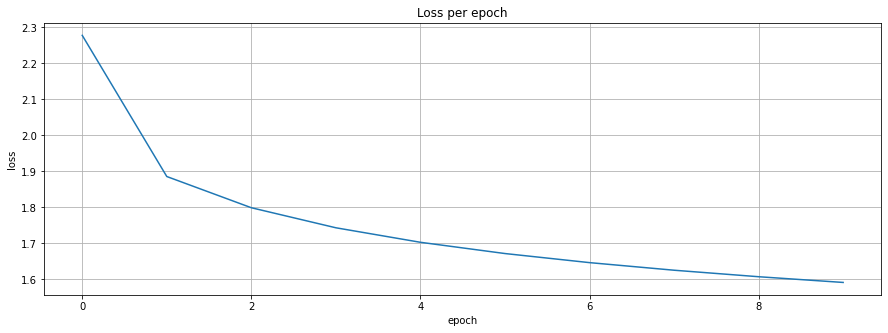

In [34]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.plot(loss_list)
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

In [35]:
class_correct = [0 for x in range(len(phones_dict.keys()))]
class_total = [0 for x in range(len(phones_dict.keys()))]

nnet.cpu()

with torch.no_grad():
    correct_cnt = 0
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(ftr).float()
        output = nnet.forward(ftr)
        predicted_label = output.argmax().item()
        
        correct_cnt += (predicted_label == true_label)
        class_correct[predicted_label] += (predicted_label == int(true_label))
        class_total[int(true_label)] += 1
        
print("Total frame accuracy is {:.3f}\n".format(correct_cnt / data_set.valid.shape[0]))

for idx, phone in enumerate(phones_dict.keys()):
    if class_total[idx]:
        print('{:3s}: {:.2f} : {}/{}'.format(phone, class_correct[idx] / class_total[idx], \
                                                     class_correct[idx], class_total[idx]))

  0%|          | 0/128635 [00:00<?, ?it/s]

Total frame accuracy is 0.531

SIL: 0.96 : 21803/22620
SPN: 0.00 : 0/553
AA0: 0.00 : 0/32
AA1: 0.46 : 810/1780
AA2: 0.00 : 0/89
AE0: 0.00 : 0/64
AE1: 0.53 : 1889/3565
AE2: 0.01 : 1/93
AH0: 0.38 : 2150/5670
AH1: 0.24 : 484/1978
AH2: 0.00 : 0/52
AO0: 0.00 : 0/16
AO1: 0.41 : 809/1960
AO2: 0.00 : 0/58
AW0: 0.00 : 0/2
AW1: 0.36 : 408/1142
AW2: 0.00 : 0/30
AY0: 0.00 : 0/49
AY1: 0.54 : 1550/2863
AY2: 0.00 : 0/188
B  : 0.22 : 353/1607
CH : 0.16 : 134/858
D  : 0.34 : 1383/4019
DH : 0.34 : 726/2105
EH0: 0.00 : 0/66
EH1: 0.32 : 917/2858
EH2: 0.00 : 0/93
ER0: 0.37 : 990/2670
ER1: 0.13 : 130/967
ER2: 0.00 : 0/10
EY0: 0.00 : 0/32
EY1: 0.44 : 1038/2352
EY2: 0.00 : 0/130
F  : 0.56 : 1322/2355
G  : 0.19 : 158/854
HH : 0.34 : 730/2135
IH0: 0.09 : 252/2766
IH1: 0.18 : 421/2380
IH2: 0.00 : 0/112
IY0: 0.41 : 899/2212
IY1: 0.60 : 1385/2293
IY2: 0.00 : 0/73
JH : 0.23 : 156/687
K  : 0.52 : 1603/3096
L  : 0.66 : 2780/4224
M  : 0.45 : 1395/3085
N  : 0.64 : 3934/6130
NG : 0.32 : 420/1302
OW0: 0.01 : 1/194
OW1: 0

### Распознавание по словарю с помощью нейронной сети

In [13]:
# теперь будем распознавать по словарю, состоящему из конечных слов
# для этого нужно загрузить файл лексикона, который определяет из каких фонем состоят наши слова
def load_lexicon_dict(lexicon_file):
    lexicon_dict = {}
    with open(lexicon_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            lexicon_dict[line[0]] = line[1:]
    return lexicon_dict

In [14]:
class AcousticModel:
    def __init__(self, phone_name, phone_index, priors_list):
        self.phone_name = phone_name
        self.phone_index = phone_index
        self.phone_prior = priors_list[phone_index]
        
    def distance(self, input_feats, nnet):
        with torch.no_grad():
            predicts = nnet.forward(torch.tensor(input_feats, dtype=torch.float32))
            softmax = torch.nn.functional.softmax(predicts, dim=0)
        return -np.log(softmax[self.phone_index].item() / self.phone_prior)

class State:
    def __init__(self, model, index):  
        self.model = model                     # вектор признаков узла
        self.is_final = False                  # является ли этот узел финальнвм в слове
        self.word = None                       # слово эталона (назначается только для финального узла)
        self.best_token = None                 # лучший токен (по минимуму дистанции) в узле
        self.current_word = None               # текущее слово эталона
        self.next_states = []                  # список следующих узлов
        self.index = index                     # индекс узла 

        
def load_graph(lexicon_dict, phones_dict, priors_list):
    start_state = State(None, 0)
    graph = [start_state, ]
    state_index = 1
    for word in lexicon_dict.keys():
        previous_state = start_state
        for phone in lexicon_dict[word]:
            state = State(AcousticModel(phone, phones_dict[phone], priors_list), state_index)
            state.current_word = word           # слово эталона теперь будет храниться в каждом узле
            state.next_states.append(state)     # add loop
            previous_state.next_states.append(state)
            previous_state = state 
            graph.append(state)
            state_index += 1
        if state:
            state.word = word
            state.is_final = True
    return graph

In [15]:
class Token:
    def __init__(self, state, dist=0.0, word=""):
        self.state = state       # стейт графа, в котором токен находится в текущий момент
        self.dist = dist         # общая накопленная дистанция пути, пройденного токеном
        self.word = word         # слово, которое распозналось токеном
        self.alive = True


def beam_pruning(next_tokens, threshold):   
    alive_tokens = [token for token in next_tokens if token.alive]
    best_token = alive_tokens[np.argmin([token.dist for token in alive_tokens if token.alive])]
    for token in next_tokens:
        if token.dist > best_token.dist + threshold:
            token.alive = False
    return next_tokens


def state_pruning(next_tokens):
    for i in range(len(next_tokens)): 
        state_index = next_tokens[i].state.index
        if not graph[state_index].best_token:
            graph[state_index].best_token = next_tokens[i]
        else:
            if next_tokens[i].dist <= graph[state_index].best_token.dist:
                graph[state_index].best_token.alive = False
                graph[state_index].best_token = next_tokens[i]
            else:
                next_tokens[i].alive = False
    for token in next_tokens:                           
        index = token.state.index                        
        if graph[index].best_token:                     
            graph[index].best_token = None              
    return next_tokens


def recognize(filename, features, graph, nnet, recognition_results, beam_threshold):

    start_state = graph[0]
    active_tokens = [Token(start_state), ]
    next_tokens = []
    
    for frame in range(len(features)):
        ftr_frame = features[frame]
        for token in active_tokens:
            if token.alive:
                for transition_state in token.state.next_states:
                    new_token = Token(transition_state, token.dist, token.word)
                    new_token.dist += transition_state.model.distance(ftr_frame, nnet)
                    next_tokens.append(new_token)
        # state and beam prunings:
        next_tokens = state_pruning(next_tokens)         
        next_tokens = beam_pruning(next_tokens, beam_threshold) 

        active_tokens = next_tokens
        next_tokens = []                                    
        
    # поиск финальных токенов:
    final_tokens = []
    for token in active_tokens:
        if token.state.is_final and token.alive:
            final_tokens.append(token)

    # если нет финальных, то берем лучший из выживших:
    if len(final_tokens) != 0:
        win_token = final_tokens[np.argmin([token.dist for token in final_tokens])]
    else:
        alive_tokens = [token for token in active_tokens if token.alive]
        win_token = alive_tokens[np.argmin([token.dist for token in alive_tokens])]
        win_token.state.word = win_token.state.current_word

    # вывод результата
    print(f"result: {filename:<27} ==> {win_token.state.word}")

    # совпадает ли запись с полученным эталоном:  
    record_word = filename.split('_')[0]
    etalon_word = win_token.state.word.split('_')[0]
    recognition_results.append(etalon_word.lower() == record_word)

    return recognition_results

In [16]:
def run_recognizer(records_data_dict, graph, nnet, beam_threshold=10):
    start_time = time.time()
    recognition_results = []

    for filename in records_data_dict.keys():    
        recognition_results = recognize(filename,
                                        records_data_dict[filename],
                                        graph, nnet,
                                        recognition_results, beam_threshold)

    print("-" * 60)
    print(f"WER is: {(1 - sum(recognition_results)/len(recognition_results))*100:.2f}%")
    print(f"Total time is: {time.time() - start_time:.2f} sec")
    print("-" * 60)

### Запустим распознавание на базе YES_NO

In [36]:
lexicon_file = 'data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/yes_no/records")

records_data_dict = {
    k: make_side_context(data, side_context=side_context)
    for k, data in records_data_dict.items()
}

run_recognizer(records_data_dict, graph, nnet.cpu(), beam_threshold=10)

  0%|          | 0/10 [00:00<?, ?it/s]

result: yes_fe1916ba_nohash_0       ==> YES
result: no_ad89eb1e_nohash_0        ==> NO
result: no_41474817_nohash_0        ==> NO
result: no_4abb2400_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> YES
result: yes_39a12648_nohash_0       ==> YES
result: no_49af4432_nohash_0        ==> NO
result: yes_ff63ab0b_nohash_0       ==> YES
result: no_4394fc7c_nohash_0        ==> NO
result: yes_fc94edb0_nohash_0       ==> YES
------------------------------------------------------------
WER is: 0.00%
Total time is: 0.79 sec
------------------------------------------------------------


### Запустим распознавание на базе Digits

In [37]:
lexicon_file = 'data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/digits/records")
records_data_dict = {
    k: make_side_context(data, side_context=side_context)
    for k, data in records_data_dict.items()
}
run_recognizer(records_data_dict, graph, nnet.cpu(), beam_threshold=100)

  0%|          | 0/20 [00:00<?, ?it/s]

result: six_ffd2ba2f_nohash_0       ==> SIX
result: one_ffa76c4a_nohash_0       ==> ONE
result: four_ffbb695d_nohash_0      ==> FOUR
result: four_fce65496_nohash_0      ==> FOUR
result: six_ffbb695d_nohash_0       ==> SIX
result: zero_f92e49f3_nohash_3      ==> ZERO
result: five_f852895b_nohash_0      ==> FIVE
result: seven_fd32732a_nohash_0     ==> SEVEN
result: eight_da584bc0_nohash_4     ==> EIGHT
result: one_fc2411fe_nohash_0       ==> NINE
result: five_ffd2ba2f_nohash_0      ==> FIVE
result: nine_fbe51750_nohash_0      ==> NINE
result: two_fce65496_nohash_0       ==> TWO
result: zero_f852895b_nohash_0      ==> ZERO
result: three_fce96bac_nohash_0     ==> THREE
result: nine_ccea893d_nohash_0      ==> NINE
result: three_feb1d305_nohash_0     ==> THREE
result: eight_daf230ac_nohash_0     ==> EIGHT
result: two_fb2f3242_nohash_0       ==> TWO
result: seven_fe5c4a7a_nohash_0     ==> SEVEN
------------------------------------------------------------
WER is: 5.00%
Total time is: 12.33 sec

### <b>Задание №1</b> (5 баллов):
Реализовать контексты для входных признаков путем конкатенации кадров слева и справа от текущего. Не забудьте поддержать это и в функции распознавания. Насколько улучшилось качество на дата сетах?

![](https://drive.google.com/uc?export=view&id=1ft0z6CPhX20cJnA373uLoYwHPEagaKyo)

### **Ответ**:
переработку фреймов реализовал через функцию `make_side_context` которая находтся перед блоком с `combain_data` из заготовки, так же пришлось применить эту функцию к данным YES_NO и Digits. Сделал это прямо в блоках кде идёт предсказание точности.

Запомним значения которые были изначально:\
Лучший лосс: \
loss is: 2.0941

Точность на фреймах:\
Total frame accuracy is 0.416

распознавание на базе YES_NO:\
WER is: 20.00%

распознавание на базе Digits:\
WER is: 20.00%

---
Значение полученые с использованием `side_context=2`:


Лучший лосс снизился до:\
loss is: 1.6072

Точность на фонемах поднялась до:\
Total frame accuracy is 0.531

распознавание на базе YES_NO:\
WER is: 0.00%

распознавание на базе Digits:\
WER is: 5.00%

---
В целом видно существенное улучшение точности предсказаний.

### <b>Задание №2</b> (5 баллов):
Повысить качество классификации фонем за счет улучшения архитектуры нейронной сети, оптимизатора, расписания скорости обучения, других речевых признаков и т.п. Составить небольшой отчет на основе результатов перебора использованных способов. 

### **Ответ**:
Попробуем сконфигурировать сеть немного посерьёзней, сделаем побольше скрытых слоев и добавим дропаутов:

In [46]:
class MyNNet_v2(torch.nn.Module):

    def __init__(self, input_dim, output_dim):
        super(MyNNet_v2, self).__init__()
        # params:
        hl1 = 1024
        hl2 = 1024
        hl3 = 1024
        hl4 = 1024


        self.ff_net = torch.nn.Sequential(
            nn.Linear(input_dim, hl1),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Linear(hl1, hl2),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Linear(hl2, hl3),
            nn.ReLU(),
            #nn.Dropout(0.2),
            nn.Linear(hl3, hl4),
            nn.ReLU(),
            nn.Linear(hl4, output_dim)
        )


    def forward(self, x):
        x = self.ff_net(x)
        return (x)

Скопипастим и чуть чуть подправим код для обучения:

Увеличим количество эпох до 20

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data:
data_set = CommonDataSet(data_list, device)

batch_size = 256

# training network model:
start = time.time() 
nnet = MyNNet_v2(input_dim=(data_list[0].shape[0] - 1),
            output_dim=len(phones_dict.keys())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.001)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=5, gamma=0.1
)

loss_list = []

print('TRAINIG STARTED...')
for epoch in range(20):  
    running_loss = 0
    counter = 0
    for batch_xs, batch_ys in tqdm(data_set.next_batch(batch_size), \
                                   total=data_set.num_batches(batch_size), \
                                   desc='epoch {}'.format(epoch)):
        optimizer.zero_grad()
        output = nnet(batch_xs)

        loss = criterion(output, batch_ys)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        counter += 1
        
    print('loss is: {:.4f}'.format((running_loss / counter)))
    loss_list.append(running_loss / counter)
    
end = time.time()
minutes = (end - start) // 60
seconds = np.mod((end - start), 60)
print('Time is: {} min {} sec'.format(int(minutes), int(seconds)))

TRAINIG STARTED...


epoch 0:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.5943


epoch 1:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.3914


epoch 2:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.3447


epoch 3:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.3171


epoch 4:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.2976


epoch 5:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.2866


epoch 6:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.2766


epoch 7:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.2677


epoch 8:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.2609


epoch 9:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.2555


epoch 10:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.2499


epoch 11:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.2457


epoch 12:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.2429


epoch 13:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.2378


epoch 14:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.2306


epoch 15:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.2291


epoch 16:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.2199


epoch 17:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.2201


epoch 18:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.2140


epoch 19:   0%|          | 0/4522 [00:00<?, ?it/s]

loss is: 1.2075
Time is: 5 min 32 sec


In [48]:
class_correct = [0 for x in range(len(phones_dict.keys()))]
class_total = [0 for x in range(len(phones_dict.keys()))]

nnet.cpu()

with torch.no_grad():
    correct_cnt = 0
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(ftr).float()
        output = nnet.forward(ftr)
        predicted_label = output.argmax().item()
        
        correct_cnt += (predicted_label == true_label)
        class_correct[predicted_label] += (predicted_label == int(true_label))
        class_total[int(true_label)] += 1
        
print("Total frame accuracy is {:.3f}\n".format(correct_cnt / data_set.valid.shape[0]))

for idx, phone in enumerate(phones_dict.keys()):
    if class_total[idx]:
        print('{:3s}: {:.2f} : {}/{}'.format(phone, class_correct[idx] / class_total[idx], \
                                                     class_correct[idx], class_total[idx]))

  0%|          | 0/128635 [00:00<?, ?it/s]

Total frame accuracy is 0.624

SIL: 0.96 : 21869/22817
SPN: 0.01 : 4/630
AA0: 0.04 : 2/45
AA1: 0.50 : 880/1747
AA2: 0.03 : 3/92
AE0: 0.02 : 1/65
AE1: 0.64 : 2298/3581
AE2: 0.00 : 0/108
AH0: 0.47 : 2641/5673
AH1: 0.36 : 692/1920
AH2: 0.00 : 0/46
AO0: 0.00 : 0/20
AO1: 0.59 : 1158/1952
AO2: 0.01 : 1/69
AW0: 0.00 : 0/3
AW1: 0.59 : 654/1106
AW2: 0.00 : 0/32
AY0: 0.04 : 2/46
AY1: 0.69 : 1997/2903
AY2: 0.04 : 9/200
B  : 0.51 : 838/1636
CH : 0.29 : 259/889
D  : 0.42 : 1668/3965
DH : 0.56 : 1148/2042
EH0: 0.02 : 1/52
EH1: 0.43 : 1219/2866
EH2: 0.00 : 0/88
ER0: 0.48 : 1328/2767
ER1: 0.29 : 275/940
ER2: 0.00 : 0/13
EY0: 0.03 : 1/31
EY1: 0.66 : 1481/2247
EY2: 0.01 : 2/143
F  : 0.66 : 1541/2326
G  : 0.44 : 349/799
HH : 0.48 : 1020/2138
IH0: 0.24 : 665/2732
IH1: 0.35 : 813/2303
IH2: 0.00 : 0/109
IY0: 0.52 : 1221/2337
IY1: 0.52 : 1210/2347
IY2: 0.02 : 1/64
JH : 0.57 : 381/674
K  : 0.66 : 2082/3155
L  : 0.67 : 2826/4206
M  : 0.58 : 1772/3060
N  : 0.68 : 4062/5987
NG : 0.46 : 595/1295
OW0: 0.01 : 3/237

Значительно увеличилось качество при следующих параметрах:

* `side_context = 5`
* 4 скрытых слоя толщиной 1024
* так же использовал шаговый шедулер для шагового снижения лёрнинг рейта
* учил на 20 эпохах
* дропауты делали результат только хуже, но я не очень умею им пользоваться. 

Точность сети выросла:\
Total frame accuracy is 0.624
